# 事前準備：共通コードの実行
* このノートブックに接続したら，まずは以下の2つの共通コード（コードAとコードB）を実行する
* これらの共通コードを実行しないと，それ以降のコードが実行できないので注意する
* また，コードAとコードBは，ノートブックに接続するたび毎回実行すること（ノートブックに接続中は，何度も実行する必要はない）
* 共通コードの詳細についての説明は割愛する（簡単な説明は第2回の「[サンプルノートブック02](https://colab.research.google.com/github/yoshida-nu/lec_datascience/blob/main/doc/datascience_notebook02.ipynb)」を参照）

In [ ]:
# コードA：日本語化ライブラリ導入
! pip install japanize-matplotlib | tail -n 1

In [2]:
# コードB：共通事前処理

# B1:余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib # matplotlib日本語化対応
import seaborn as sns

# B2:データフレーム表示用関数
from IPython.display import display

# B3:表示オプション調整
np.set_printoptions(suppress = True, precision = 3) #numpyの浮動小数点の表示精度
pd.options.display.float_format = '{:.3f}'.format #pandasでの浮動小数点の表示精度
pd.set_option('display.max_columns', None) #データフレームですべての列データを表示

# B4:グラフのデフォルトフォント指定
plt.rcParams['font.size'] = 14

# 乱数の種
random_seed = 0

# ボストン住宅データ
* 1970年代後半におけるボストンの住宅価格データ
>* URL: https://bit.ly/4hwOUgx
* オリジナルのデータはカリフォルニア大学アーバイン校の「Machine Learning Repository」にあったが現在は削除されていると思われる
* ここで利用するデータは，オリジナルのデータを加工して作成している
>* 出典: 須藤秋良, 株式会社フレアリンク: スッキリわかるPythonによる機械学習入門, インプレス, 2020
* ここでは，住宅価格を表すPRICEを予測する線形回帰モデル（目的変数がPRICE）を作成することを考える
* なお，このデータは1970年代後半における古いデータであることに注意しておく
* まずは，ボストン住宅データを読み込んで，内容を確認する
  
**［以下のコードの処理内容］**
*  1行目: ファイルのURLを変数`url`に代入
*  2行目: pandasの`read_csv`関数を使って，ファイルをDataFrameとして読み込んで，変数`df`に代入
*  3行目: `display`関数を使ってデータ（`df`の内容）を表示

In [3]:
url = 'https://bit.ly/4hwOUgx'
df = pd.read_csv(url)
display(df)

,CRIME,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,PRICE
0,high,0.000,18.100,0,0.718,3.561,87.900,1.613,24.000,666,20.200,7.120,27.500
1,low,0.000,8.140,0,0.538,5.950,82.000,3.990,4.000,307,21.000,27.710,13.200
2,very_low,82.500,2.030,0,0.415,6.162,38.400,6.270,2.000,348,14.700,7.430,24.100
3,low,0.000,21.890,0,0.624,6.151,97.900,1.669,4.000,437,21.200,18.460,17.800
4,high,0.000,18.100,0,0.614,6.980,67.600,2.533,24.000,666,20.200,11.660,29.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,high,0.000,18.100,0,0.740,6.219,100.000,2.005,24.000,666,20.200,16.590,18.400
96,high,0.000,18.100,0,0.655,5.759,48.200,3.067,24.000,666,20.200,14.130,19.900
97,high,0.000,18.100,0,0.671,6.380,96.200,1.386,24.000,666,20.200,23.690,13.100
98,low,0.000,9.900,0,0.544,5.914,83.200,3.999,4.000,304,18.400,18.330,17.800


各列名と意味は以下のとおり．

|**列名**| **意味** |
|:--|:--|
|CRIME| その地域の犯罪発生率（high / low / very_low） |
|ZN| 25,000平方フィートを超える住居区画の占める割合（広い部屋の割合） |
|INDUS| 非小売業が占める面積の割合 |
|CHAS| チャールズ川の付近かどうかのダミー変数（1: 川周辺，0: それ以外） |
|NOX| 窒素酸化物の濃度 |
|RM| 1戸当たりの平均部屋数 |
|AGE| 1940年より前に建てられた物件の割合（築年数が35～40年ほどの割合） |
|DIS| ボストン市内の5つの雇用施設までの距離 |
|RAD| 主要高速道路へのアクセスしやすさの指標 |
|TAX| 10,000ドル当たりの固定資産税率 |
|PTRATIO| その地域の教員1人当たりの生徒数 |
|LSTAT| その地域の低所得者の割合 |
|PRICE| その地域の住宅平均価格（1,000ドル単位） |


# データの前処理

## ダミー変数化
* CRIME列は数値ではないので，ダミー変数化を行う
* ダミー変数化は，`get_dummies`関数を用いて行う
>* 詳細は第5回の「[サンプルノートブック05](https://colab.research.google.com/github/yoshida-nu/lec_datascience/blob/main/doc/datascience_notebook05.ipynb)」や 「[ノートブック：SeriesとDataFrameの基本操作](https://colab.research.google.com/github/yoshida-nu/lec_datascience/blob/main/doc/datascience_notebook_se_df.ipynb)」を参照
* CRIME列には3種類の値（high / low / very_low）があるので，`get_dummies`関数によって，3列のDataFrameが作成される
* このうちの2列（例えば「low」と「very_low」）がともに「`False` (0)」であれば，もう1列（「high」）の値は必ず「`True` (1)」となり，どちらかの列が「`True` (1)」であれば「`False` (0)」となるので，3列のうちの2列のデータがあれば十分であることがわかる
* `get_dummies`関数の引数に`drop_first = True`を指定することで，ダミー変数化したDataFrameの第1列目が削除される（デフォルトは`False`）
* 以下のコードでは，CRIME列をダミー変数化し，`concat`関数を使ってボストン住宅データ（DataFrame）と結合している
>* `concat`関数の詳細は第5回の「[サンプルノートブック05](https://colab.research.google.com/github/yoshida-nu/lec_datascience/blob/main/doc/datascience_notebook05.ipynb)」や 「[ノートブック：SeriesとDataFrameの基本操作](https://colab.research.google.com/github/yoshida-nu/lec_datascience/blob/main/doc/datascience_notebook_se_df.ipynb)」を参照
* さらに，`drop`メソッドを使って，結合したDataFrameからCRIME列を削除している
>* `drop`メソッドの詳細は「[ノートブック：SeriesとDataFrameの基本操作](https://colab.research.google.com/github/yoshida-nu/lec_datascience/blob/main/doc/datascience_notebook_se_df.ipynb)」を参照
  
**［以下のコードの処理内容］**
* 1～2行目: ファイルの読み込み
* 3行目: `get_dummies`関数を使って，CRIME列（`df['CRIME']`）をダミー変数化し，その結果を変数`dummy`に代入
* 4行目: `concat`関数を使って，2つのDataFrame `df`と`dummy`を結合し，その結果を変数`df`に代入
* 5行目: `drop`メソッドで，CRIME列を削除し，その結果を変数`df`に代入
* 6行目: `display`関数を使って，変数`df`の内容を表示

In [4]:
url = 'https://bit.ly/4hwOUgx'
df = pd.read_csv(url)
dummy = pd.get_dummies(df['CRIME'], drop_first = True)
df = pd.concat([df, dummy], axis = 1)
df = df.drop(['CRIME'], axis = 1)
display(df)

,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,PRICE,low,very_low
0,0.000,18.100,0,0.718,3.561,87.900,1.613,24.000,666,20.200,7.120,27.500,False,False
1,0.000,8.140,0,0.538,5.950,82.000,3.990,4.000,307,21.000,27.710,13.200,True,False
2,82.500,2.030,0,0.415,6.162,38.400,6.270,2.000,348,14.700,7.430,24.100,False,True
3,0.000,21.890,0,0.624,6.151,97.900,1.669,4.000,437,21.200,18.460,17.800,True,False
4,0.000,18.100,0,0.614,6.980,67.600,2.533,24.000,666,20.200,11.660,29.800,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000,18.100,0,0.740,6.219,100.000,2.005,24.000,666,20.200,16.590,18.400,False,False
96,0.000,18.100,0,0.655,5.759,48.200,3.067,24.000,666,20.200,14.130,19.900,False,False
97,0.000,18.100,0,0.671,6.380,96.200,1.386,24.000,666,20.200,23.690,13.100,False,False
98,0.000,9.900,0,0.544,5.914,83.200,3.999,4.000,304,18.400,18.330,17.800,True,False


## データを「訓練/検証データ」と「テストデータ」に分割

### ホールドアウト法の改善
* これまでのホールドアウト法による学習では，様々なモデルで何度も学習させて，テストデータに対して当てはまりのよいモデルを選択することができる
* 「様々なモデル」とは
>* 分類木モデルの場合: 最大深さを変えることで様々なモデルを表現できる
>* 線形回帰モデルの場合: 説明変数の数や組み合わせを変えることで様々なモデルを表現できる
* この状況は，テストデータに都合がいいようにモデルをチューニングしていると言える
* そこで，この問題に対処するためにホールドアウト法を改善する
>* まず，これまでどおり訓練データとテストデータに分割する
>* 訓練データをさらに2つに分割し，一方はモデルの学習用として，もう一方は学習には利用せずモデルのチューニング（検証）用として利用する ⇒ 以降は「訓練/検証データ」と呼ぶ
>* テストデータは，これまでと同様にチューニング後の学習済みモデルを評価するために利用する
* 欠損値や外れ値への対処は「訓練/検証データ」に対して行う
* 一般には「テストデータ」は何もせずにとっておく
>* 「訓練/検証データ」で様々な対処を試し，最終的に確定した対処をテストデータにも施す
* この方法では，説明変数と目的変数に分割する前に，訓練/検証データとテストデータの分割を行う
>* 分割方法はこれまでと同様
>* 例えば，第3回の「[サンプルノートブック03](https://colab.research.google.com/github/yoshida-nu/lec_datascience/blob/main/doc/datascience_notebook03.ipynb)」を参照

**［以下のコードの処理内容］**
* 1～5行目: ファイルの読み込みとダミー変数化 ⇒ 結果を変数`df`に代入
* 6行目: `model_selection`モジュールの`train_test_split`関数の読み込み
* 7行目: `train_test_split`関数を使って，`df`を訓練/検証データ `train_val` とテストデータ `test` に分割
>* `test_size = 0.2`として，訓練/検証データを8割，テストデータを2割に分割
>* `random_state = random_seed`として，乱数を固定する ⇒ 結果が同じになる
* 8行目: `print`関数で区切り線「================ train_val ================」を表示
* 9行目: `display`関数で変数`train_val`（訓練/検証データ）を表示
* 10行目: `print`関数で区切り線「================ test ================」を表示
* 11行目: `display`関数で変数`test`（テストデータ）を表示


In [5]:
url = 'https://bit.ly/4hwOUgx'
df = pd.read_csv(url)
dummy = pd.get_dummies(df['CRIME'], drop_first = True)
df = pd.concat([df, dummy], axis = 1)
df = df.drop(['CRIME'], axis = 1)
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(df, test_size = 0.2, random_state = random_seed)
print('================ train_val ================')
display(train_val)
print('================ test ================')
display(test)

================ train_val ================


,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,PRICE,low,very_low
43,22.000,5.860,0,0.431,6.108,34.900,8.056,7.000,330,19.100,9.160,24.300,True,False
62,22.000,5.860,0,0.431,6.957,6.800,8.907,7.000,330,19.100,3.530,29.600,False,True
3,0.000,21.890,0,0.624,6.151,97.900,1.669,4.000,437,21.200,18.460,17.800,True,False
71,80.000,3.640,0,0.392,6.108,32.000,9.220,1.000,315,16.400,6.570,21.900,False,True
45,21.000,5.640,0,0.439,5.963,45.700,6.815,4.000,243,16.800,13.450,19.700,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.000,18.100,0,0.655,5.759,48.200,3.067,24.000,666,20.200,14.130,19.900,False,False
67,0.000,5.190,0,0.515,6.310,38.500,6.458,5.000,224,20.200,6.750,20.700,False,True
64,28.000,15.040,0,0.464,6.249,77.300,3.615,4.000,270,18.200,10.590,20.600,False,True
47,0.000,2.890,0,0.445,6.625,57.800,3.495,2.000,276,18.000,6.650,28.400,False,True


================ test ================


,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,PRICE,low,very_low
26,0.000,12.830,0,0.437,6.273,6.000,4.252,5.000,398,18.700,6.780,24.100,False,True
86,0.000,3.410,0,0.489,7.007,86.300,3.422,2.000,270,17.800,5.500,23.600,False,True
2,82.500,2.030,0,0.415,6.162,38.400,6.270,2.000,348,14.700,7.430,24.100,False,True
55,0.000,18.100,0,0.718,6.411,100.000,1.859,24.000,666,20.200,15.020,16.700,False,False
75,0.000,3.240,0,0.460,6.333,17.200,5.215,4.000,430,16.900,7.340,22.600,False,True
93,0.000,19.580,0,0.871,5.186,93.800,1.530,5.000,403,14.700,28.320,17.800,False,False
16,0.000,9.900,0,0.544,6.266,82.800,3.263,4.000,304,18.400,7.900,21.600,True,False
73,55.000,3.780,0,0.484,6.874,28.100,6.465,5.000,370,17.600,4.610,31.200,False,True
54,0.000,9.900,0,0.544,6.382,67.200,3.533,4.000,304,18.400,10.360,23.100,True,False
95,0.000,18.100,0,0.740,6.219,100.000,2.005,24.000,666,20.200,16.590,18.400,False,False


## 欠損値の確認と対処

### 欠損値の確認
* これまでと同様にして，訓練/検証データ `train_val` に欠損値があるか確認する
* 確認が終わったら，テストデータ `test` に対しても同様に欠損値の確認を行っておく（10行目の`train_val`を`test`に置き換えて実行）
  
**［以下のコードの処理内容］**
* 1～5行目: ファイルの読み込みとダミー変数化 ⇒ 結果を変数`df`に代入
* 6～7行目: `df`を訓練/検証データ `train_val` とテストデータ `test` に分割
* 8行目: `isnull`メソッドと`sum`メソッドを組み合わせて，各列の欠損値の数を計算して，`display`関数で表示する
* 実行結果より，NOX列に欠損値があることが確認できる

In [6]:
url = 'https://bit.ly/4hwOUgx'
df = pd.read_csv(url)
dummy = pd.get_dummies(df['CRIME'], drop_first = True)
df = pd.concat([df, dummy], axis = 1)
df = df.drop(['CRIME'], axis = 1)
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(df, test_size = 0.2, random_state = random_seed)
display(pd.DataFrame(train_val.isnull().sum(), columns = ['欠損値の数']))

,欠損値の数
ZN,0
INDUS,0
CHAS,0
NOX,1
RM,0
AGE,0
DIS,0
RAD,0
TAX,0
PTRATIO,0


### 欠損値への対処
* NOX列に欠損値があるので，`fillna`メソッドと`mean`メソッドを使って算術平均で穴埋めをする
  
**［以下のコードの処理内容］**
* 1～5行目: ファイルの読み込みとダミー変数化 ⇒ 結果を変数`df`に代入
* 6～7行目: `df`を訓練/検証データ `train_val` とテストデータ `test` に分割
* 8行目: `fillna`メソッドと`mean`メソッドを使って，`train_val`のNOX列の欠損値を算術平均で穴埋めし，その結果を`train_val`に代入
* 対処後の`train_val`に対して，列ごとの欠損値数を確認（1つ前のコードと同様）

In [7]:
url = 'https://bit.ly/4hwOUgx'
df = pd.read_csv(url)
dummy = pd.get_dummies(df['CRIME'], drop_first = True)
df = pd.concat([df, dummy], axis = 1)
df = df.drop(['CRIME'], axis = 1)
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(df, test_size = 0.2, random_state = random_seed)
train_val = train_val.fillna(train_val.mean())
display(pd.DataFrame(train_val.isnull().sum(), columns = ['欠損値の数']))

,欠損値の数
ZN,0
INDUS,0
CHAS,0
NOX,0
RM,0
AGE,0
DIS,0
RAD,0
TAX,0
PTRATIO,0


## 外れ値の確認と削除

### 外れ値の確認
* 住宅価格を表すPRICEを目的変数とするので，各特徴量とPRICEとの散布図を作成して外れ値を確認する
* ここでは，seaborn (共通コードで`sns`としてインポート済み) の`pairplot`関数を用いて，訓練/検証データ `train_val` に対する散布図行列を作成する
>* 詳細は第2回の「[サンプルノートブック02](https://colab.research.google.com/github/yoshida-nu/lec_datascience/blob/main/doc/datascience_notebook02.ipynb)」を参照
* 以下のコードでは，訓練/検証データ `train_val` に対する散布図を作成しているが，`train_val`を`test`に変更することでテストデータ`test`に対する散布図も作成できるので，テストデータに対する散布図も作成し，外れ値がないか確認しておく

**［以下のコードの処理内容］**
* 1～5行目: ファイルの読み込みとダミー変数化 ⇒ 結果を変数`df`に代入
* 6～7行目: `df`を訓練/検証データ `train_val` とテストデータ `test` に分割
* 8行目: `fillna`メソッドと`mean`メソッドを使って，`train_val`のNOX列の欠損値を算術平均で穴埋めし，その結果を`train_val`に代入
* 9行目: `pairplot`関数を使って，`train_val`に対する散布図行列を作成
* 10行目: `show`関数で，それまでに設定した図（散布図行列）を実行画面に表示

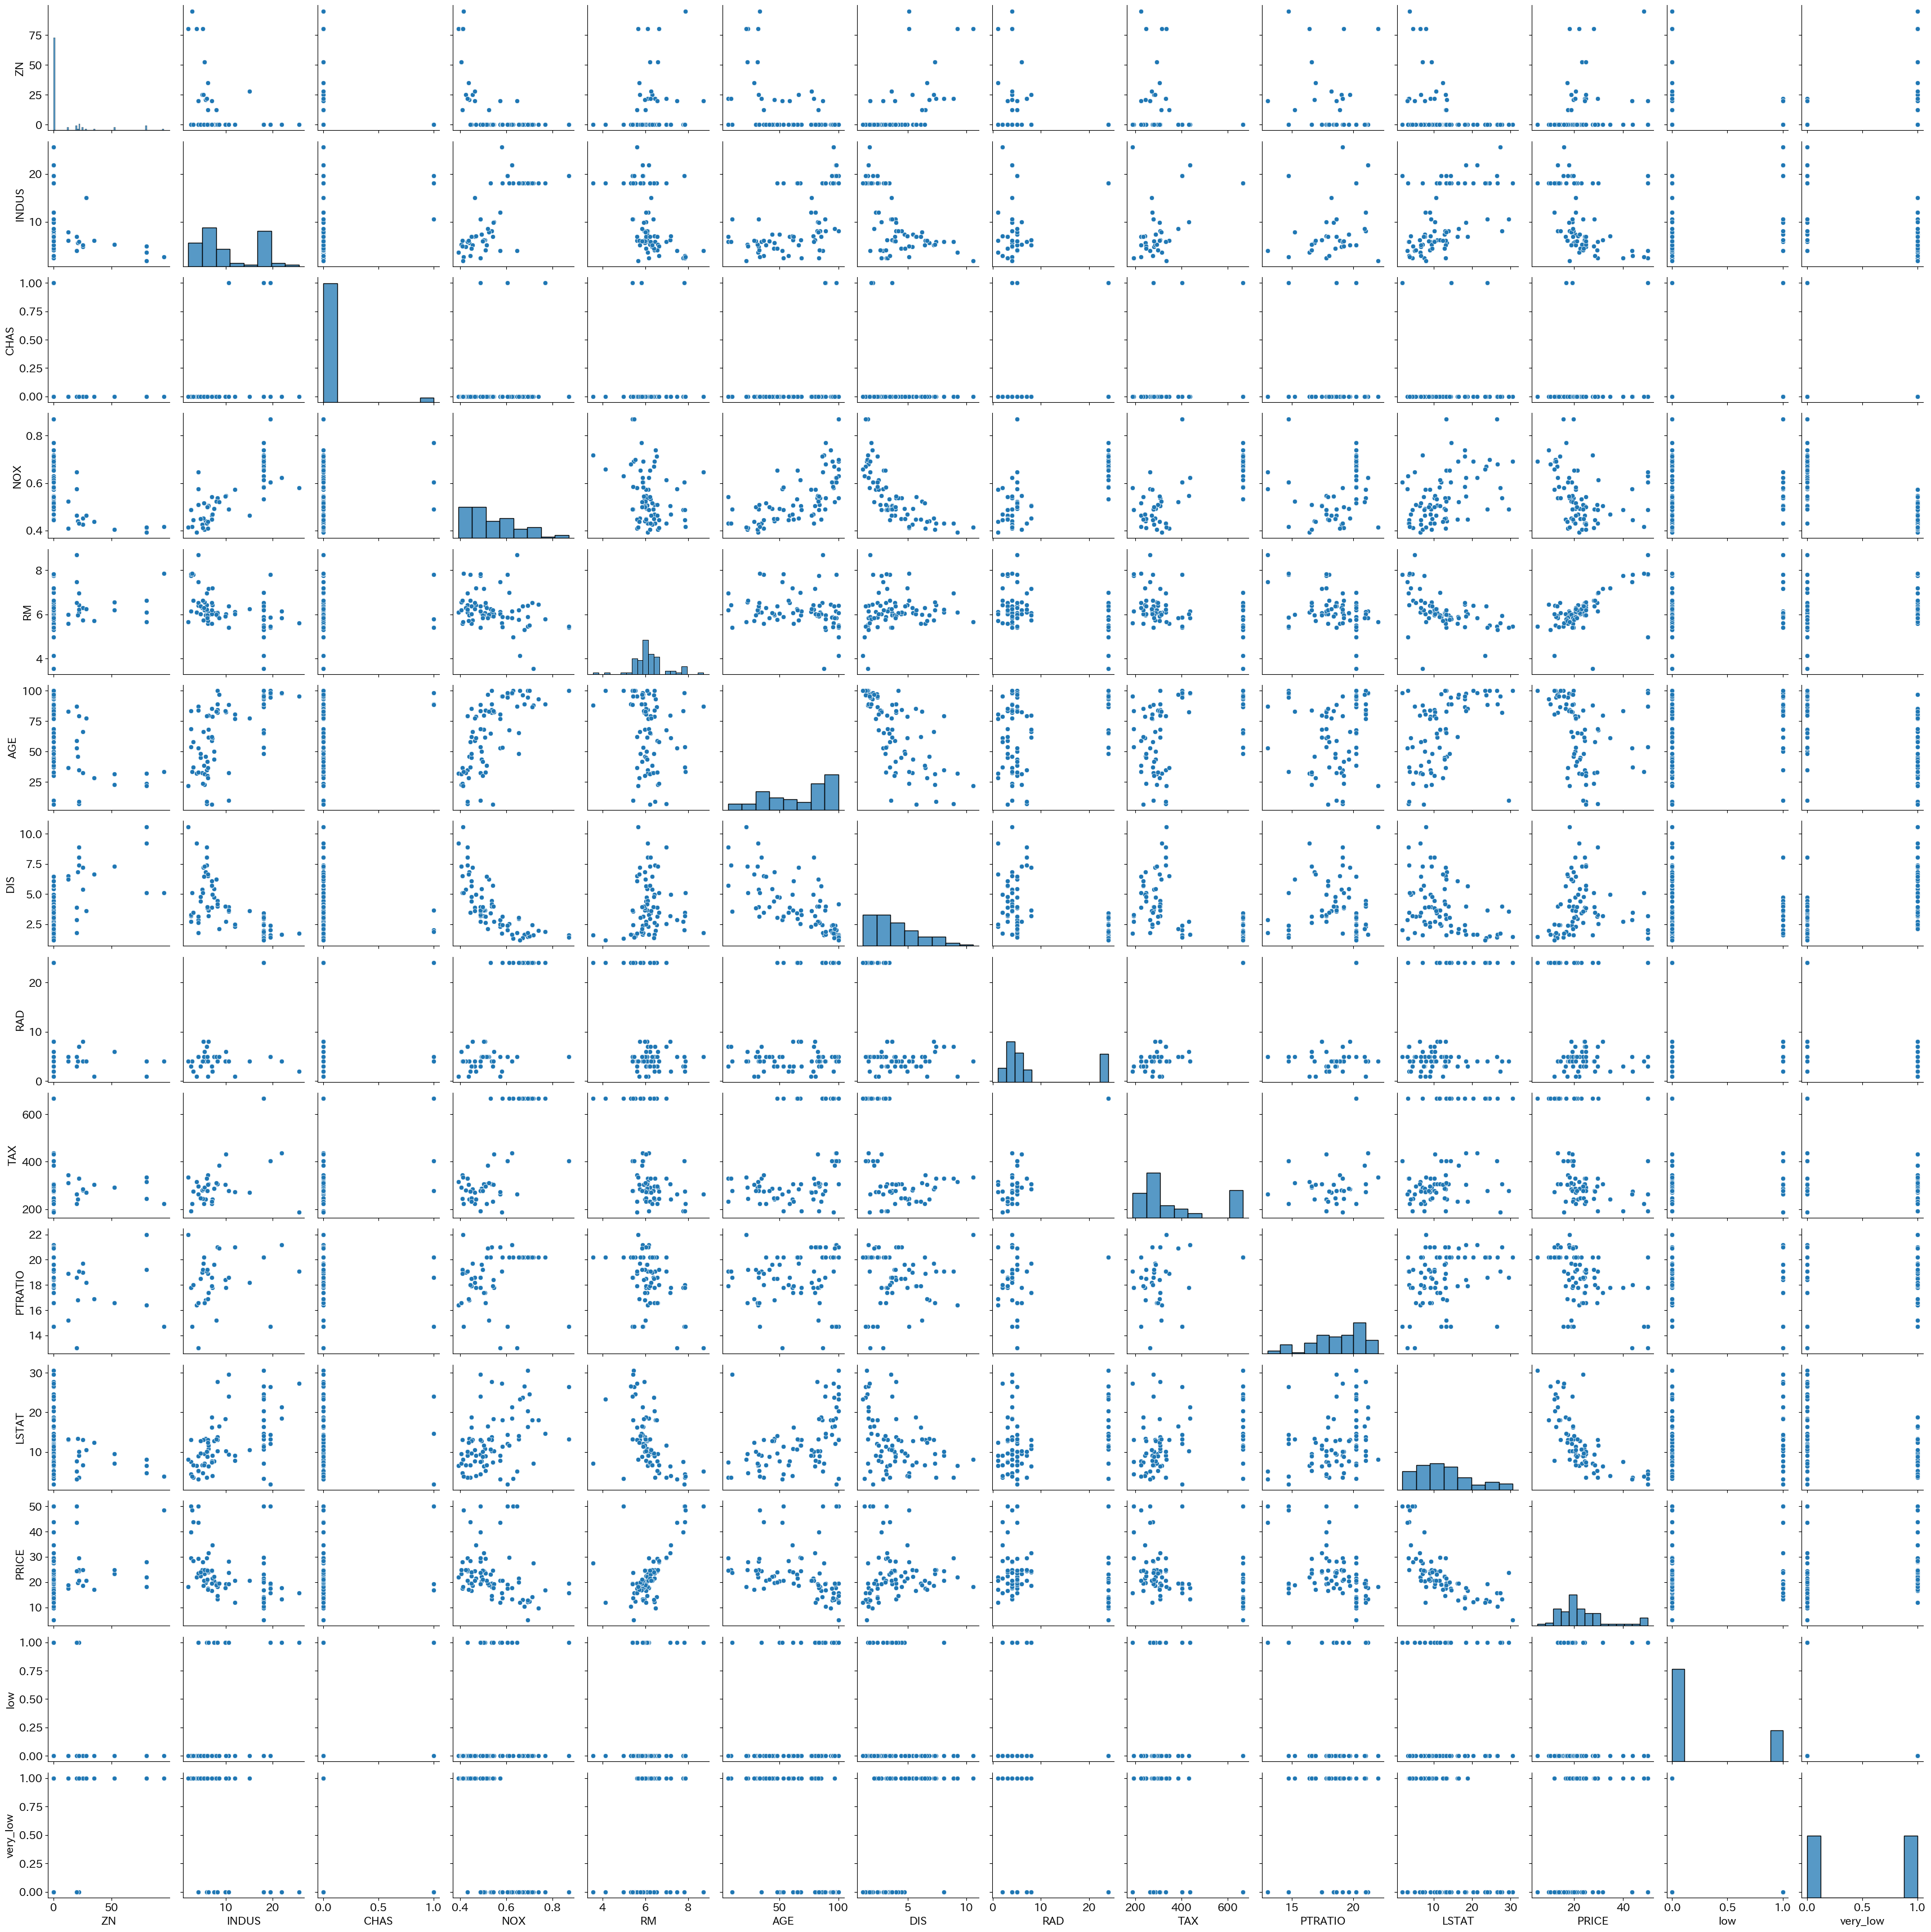

In [8]:
url = 'https://bit.ly/4hwOUgx'
df = pd.read_csv(url)
dummy = pd.get_dummies(df['CRIME'], drop_first = True)
df = pd.concat([df, dummy], axis = 1)
df = df.drop(['CRIME'], axis = 1)
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(df, test_size = 0.2, random_state = random_seed)
train_val = train_val.fillna(train_val.mean())
sns.pairplot(train_val)
plt.show()

### 外れ値の決定
* 一般に，どのデータを外れ値とするかは分析者が判断する
* 外れ値らしいものをすべて取り除いて学習すると，テストデータに外れ値が含まれている場合には，モデルの性能が劣化することがある
* そのため，場合によるが，ある程度の外れ値は残しておくほうがよい
* ここでは，`train_val`（訓練/検証データ）における以下のデータを外れ値として扱うことにする
>* RMとPRICEの散布図: RMが6未満でPRICEが40より大きいデータ
>* PTRATIOとPRICEの散布図: PTRATIOが19より大きくPRICEが40より大きいデータ
* テストデータには外れ値がないと判断した
* 確認のために以下のコードで，上記2つの散布図だけ作成する
>* 散布図は pyplot（共通コードにおいて`plt`でインポート済み）の`scatter`関数を使って作成する
  
**［以下のコードの処理内容］**
* 1～5行目: ファイルの読み込みとダミー変数化 ⇒ 結果を変数`df`に代入
* 6～7行目: `df`を訓練/検証データ `train_val` とテストデータ `test` に分割
* 8行目: `fillna`メソッドと`mean`メソッドを使って，`train_val`のNOX列の欠損値を算術平均で穴埋めし，その結果を`train_val`に代入
* 9行目: `scatter`関数を使ってRMとPRICEの散布図を作成
>*  `df['RM']`でx軸を指定
>*  `df['PRICE']`でy軸を指定
*  10～11行目: `xlabel`関数と`ylabel`関数各軸のラベルをそれぞれ「RM」「PRICE」に設定
*  12行目: `show`関数で，それまでに設定した図（RMとPRICEの散布図）を実行画面に表示
*  13～16: 同様にしてRMとPRICEの散布図を作成・表示


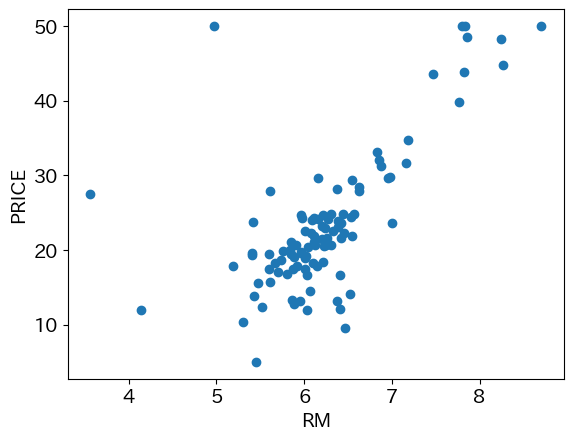

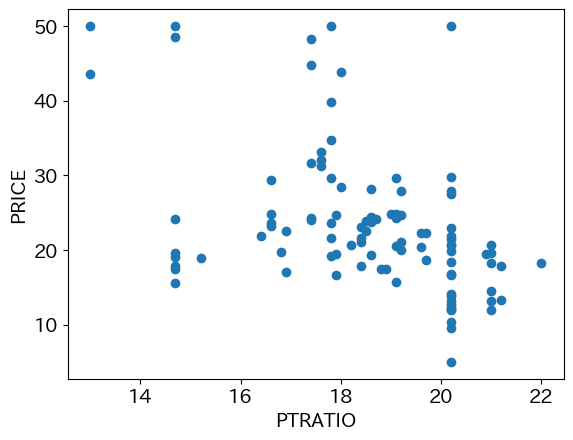

In [9]:
url = 'https://bit.ly/4hwOUgx'
df = pd.read_csv(url)
dummy = pd.get_dummies(df['CRIME'], drop_first = True)
df = pd.concat([df, dummy], axis = 1)
df = df.drop(['CRIME'], axis = 1)
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(df, test_size = 0.2, random_state = random_seed)
train_val = train_val.fillna(train_val.mean())
plt.scatter(df['RM'], df['PRICE'])
plt.xlabel('RM')
plt.ylabel('PRICE')
plt.show()
plt.scatter(df['PTRATIO'], df['PRICE'])
plt.xlabel('PTRATIO')
plt.ylabel('PRICE')
plt.show()

### 外れ値の抽出
* ここで，外れ値に該当する以下のデータを抽出する
>* 1つ目の外れ値: RMが6未満でPRICEが40より大きい
>* 2つ目の外れ値: PTRATIOが19より大きくPRICEが40より大きい
* DataFrameから，上記を条件式として検索することで抽出できる
* DataFrameの検索の詳細は「[ノートブック：SeriesとDataFrameの基本操作](https://colab.research.google.com/github/yoshida-nu/lec_datascience/blob/main/doc/datascience_notebook_se_df.ipynb)」を参照
  
**［以下のコードの処理内容］**
* 1～5行目: ファイルの読み込みとダミー変数化 ⇒ 結果を変数`df`に代入
* 6～7行目: `df`を訓練/検証データ `train_val` とテストデータ `test` に分割
* 8行目: `fillna`メソッドと`mean`メソッドを使って，`train_val`のNOX列の欠損値を算術平均で穴埋めし，その結果を`train_val`に代入
* 9行目: 1つ目の外れ値を検索して変数`out1`に代入
>* 条件式を「`(train_val['RM'] < 6) & (train_val['PRICE'] > 40)`」としてDataFrameから検索
* 10行目: 2つ目の外れ値を検索して変数`out2`に代入
>* 条件式を「`(train_val['PTRATIO'] > 19) & (train_val['PRICE' ] > 40)`」としてDataFrameから検索
* `concat`関数で`out1`と`out2`を結合し，`display`関数で表示


In [10]:
url = 'https://bit.ly/4hwOUgx'
df = pd.read_csv(url)
dummy = pd.get_dummies(df['CRIME'], drop_first = True)
df = pd.concat([df, dummy], axis = 1)
df = df.drop(['CRIME'], axis = 1)
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(df, test_size = 0.2, random_state = random_seed)
train_val = train_val.fillna(train_val.mean())
out1 = train_val[(train_val['RM'] < 6) & (train_val['PRICE'] > 40)]
out2 = train_val[(train_val['PTRATIO'] > 19) & (train_val['PRICE' ] > 40)]
display(pd.concat([out1, out2], axis = 0))

,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,PRICE,low,very_low
76,0.000,18.100,0,0.631,4.970,100.000,1.333,24.000,666,20.200,3.260,50.000,False,False
76,0.000,18.100,0,0.631,4.970,100.000,1.333,24.000,666,20.200,3.260,50.000,False,False


### 外れ値の削除
* 上のコードの実行結果から，2つの条件式によって抽出されたデータは同じデータ（インデックス「76」のデータ）であることがわかる
* このデータを`drop`メソッドで削除する
* また，外れ値が削除できたかどうかを確認するために，削除後のRMとPRICE，及びPTRATIOとPRICEの散布図をそれぞれ作成する
  
**［以下のコードの処理内容］**
* 1～5行目: ファイルの読み込みとダミー変数化 ⇒ 結果を変数`df`に代入
* 6～7行目: `df`を訓練/検証データ `train_val` とテストデータ `test` に分割
* 8行目: `fillna`メソッドと`mean`メソッドを使って，`train_val`のNOX列の欠損値を算術平均で穴埋めし，その結果を`train_val`に代入
* 9行目: `drop`メソッドで，外れ値（`train_val`のインデックス「76」の行データ）を削除し，その結果を`train_val`に代入
* 10～17行目: `scatter`関数を使って，RMとPRICEの散布図，及びRMとPRICEの散布図をそれぞれ作成・表示


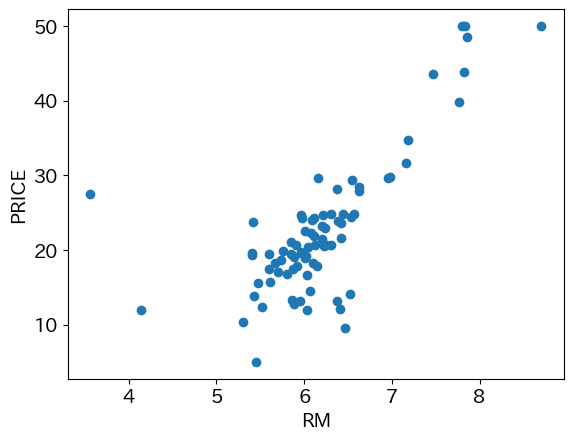

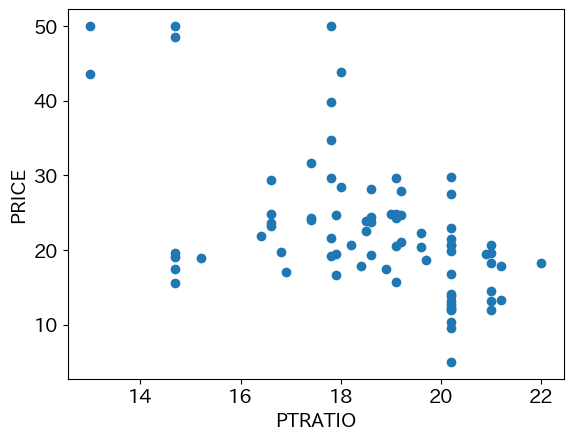

In [11]:
url = 'https://bit.ly/4hwOUgx'
df = pd.read_csv(url)
dummy = pd.get_dummies(df['CRIME'], drop_first = True)
df = pd.concat([df, dummy], axis = 1)
df = df.drop(['CRIME'], axis = 1)
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(df, test_size = 0.2, random_state = random_seed)
train_val = train_val.fillna(train_val.mean())
train_val = train_val.drop([76], axis = 0)
plt.scatter(train_val['RM'], train_val['PRICE'])
plt.xlabel('RM')
plt.ylabel('PRICE')
plt.show()
plt.scatter(train_val['PTRATIO'], train_val['PRICE'])
plt.xlabel('PTRATIO')
plt.ylabel('PRICE')
plt.show()

## 説明変数（特徴量）の選定
* 欠損値と外れ値の対処が完了したら，次は説明変数の選定を行う
* 線形重回帰モデルの学習では，目的変数に影響を与えない説明変数が含まれていると，モデルの予測性能が低下することが起こり得る
* そのため，データからどれを説明変数とするかの取捨選択は非常に重要な検討事項となる

### 目的変数との相関係数を計算
* 一般に，目的変数（ここではPRICE）と説明変数候補との相関をみて，相関が高いものだけを説明変数として選択する（相関が無いものは捨てる）といった変数選択が行われる
* 以下のコードで，PRICEとその他の各特徴量との相関係数を計算し，その結果と散布図をみて説明変数を決定する
>* 相関係数の計算の詳細は第2回の「[サンプルノートブック02](https://colab.research.google.com/github/yoshida-nu/lec_datascience/blob/main/doc/datascience_notebook02.ipynb)」を参照
  
**［以下のコードの処理内容］**
* 1～5行目: ファイルの読み込みとダミー変数化 ⇒ 結果を変数`df`に代入
* 6～7行目: `df`を訓練/検証データ `train_val` とテストデータ `test` に分割
* 8～9行目: 欠損値と外れ値への対処をし，その結果を`train_val`に代入
* 10行目: `corr`メソッドを使って，相関係数行列を計算し，その結果を変数`r`に代入
* 11行目: 相関係数行列のうちPRICEとかかわる部分（行列の1列目）だけ表示

In [12]:
url = 'https://bit.ly/4hwOUgx'
df = pd.read_csv(url)
dummy = pd.get_dummies(df['CRIME'], drop_first = True)
df = pd.concat([df, dummy], axis = 1)
df = df.drop(['CRIME'], axis = 1)
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(df, test_size = 0.2, random_state = random_seed)
train_val = train_val.fillna(train_val.mean())
train_val = train_val.drop([76], axis = 0)
r = train_val.corr()
display(pd.DataFrame(r['PRICE']))

,PRICE
ZN,0.222
INDUS,-0.471
CHAS,0.131
NOX,-0.325
RM,0.754
AGE,-0.346
DIS,0.089
RAD,-0.354
TAX,-0.433
PTRATIO,-0.542


## 訓練/検証データを訓練データと検証データに分割
* PRICEと各特徴量との散布図や相関係数から以下の列データを説明変数として選択することにする（この判断は分析者によって当然異なる）
>* RM
>* LSTAT
>* PTRATIO
* 説明変数が決定したので，次は訓練/検証データを説明変数データ（RM, LSTAT, PTRATIO）と目的変数データ（PRICE）に分割する
* さらにそれらを訓練データ（学習用）と検証データ（チューニング用）に分割する
* 分割の割合は，訓練データを8割，検証データを2割とする
  
**［以下のコードの処理内容］**
* 1～5行目: ファイルの読み込みとダミー変数化 ⇒ 結果を変数`df`に代入
* 6～7行目: `df`を訓練/検証データ `train_val` とテストデータ `test` に分割
* 8～9行目: 欠損値と外れ値への対処をし，その結果を`train_val`に代入
* 10行目: 説明変数の列名を要素とするリスト`['RM', 'LSTAT', 'PTRATIO']`を変数`x_cols`に代入
* 11行目: 目的変数の列名`'PRICE'`を変数`t_col`に代入
* 12行目: DataFrame `df` から,`df[x_cols]`で，説明変数の列だけ取り出し変数`x`に代入
* 13行目: DataFrame `df` から,`df[t_col]`で目的変数の列だけ取り出し変数`t`に代入
* 14行目: 説明変数`x`と目的変数`t`を訓練データ（8割）と検証データ（2割）に分割し，`x_train`, `x_val`, `t_train`, `t_val`にそれぞれ代入
>* 訓練データ（`x_train`と`t_train`）と検証データ（`x_val`と`t_val`）に分割
* 15～22行目: `x_train`, `x_val`, `t_train`, `t_val`の内容をそれぞれ表示


In [24]:
url = 'https://bit.ly/4hwOUgx'
df = pd.read_csv(url)
dummy = pd.get_dummies(df['CRIME'], drop_first = True)
df = pd.concat([df, dummy], axis = 1)
df = df.drop(['CRIME'], axis = 1)
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(df, test_size = 0.2, random_state = random_seed)
train_val = train_val.fillna(train_val.mean())
train_val = train_val.drop([76], axis = 0)
x_cols = ['RM', 'LSTAT', 'PTRATIO']
t_col = 'PRICE'
x = train_val[x_cols]
t = train_val[t_col]
x_train, x_val, t_train, t_val = train_test_split(x, t, test_size = 0.2, random_state = random_seed)
print('================ x_train ================')
display(x_train)
print('================ t_train ================')
display(pd.DataFrame(t_train))
print('================ x_val ================')
display(x_val)
print('================ t_val ================')
display(pd.DataFrame(t_val))


================ x_train ================


,RM,LSTAT,PTRATIO
71,6.108,6.570,16.400
41,6.096,10.260,21.000
99,5.453,30.590,20.200
40,7.470,3.160,13.000
57,6.021,10.300,17.800
...,...,...,...
67,6.310,6.750,20.200
88,4.138,23.340,20.200
65,5.427,18.140,20.200
14,6.226,10.150,19.100


================ t_train ================


,PRICE
71,21.900
41,18.200
99,5.000
40,43.500
57,19.200
...,...
67,20.700
88,11.900
65,13.800
14,20.500


================ x_val ================


,RM,LSTAT,PTRATIO
19,6.072,13.040,21.000
38,6.630,4.700,19.200
59,5.981,11.650,17.400
39,5.602,16.200,17.900
32,6.546,5.330,16.600
87,5.663,8.050,22.000
96,5.759,14.130,20.200
64,6.249,10.590,18.200
89,7.831,4.450,17.800
72,6.120,9.080,21.000


================ t_val ================


,PRICE
19,14.500
38,27.900
59,24.300
39,19.400
32,29.400
87,18.200
96,19.900
64,20.600
89,50.000
72,20.600


## データの標準化
* 線形重回帰モデルでは，複数の説明変数データを扱っているが，それぞれのデータの単位や大きさ（スケール）は異なる
* これが影響して，モデルの学習において値の大きな説明変数に引っ張られ，値の小さな説明変数の影響が小さくなることが起こり得る
* これは，モデルの予測精度を低下させる要因になり得るので，説明変数間の単位の影響を取り除く必要がある（これまでは，この処理を省略していた）
* この処理のことを**標準化**と呼ぶ
* 標準化には，scikit-learnの`preprocessing`モジュールに含まれる`StandardScaler`クラスを利用する
>* まず，`from sklearn.preprocessing import StandardScaler`で`StandardScaler`クラスを読み込む
>* 次に，`StandardScaler`クラスからオブジェクトを生成し，変数に代入する
>* そのオブジェクトに対して，`fit`メソッドを呼び出す
>* このとき，`fit`メソッドの引数には，標準化する訓練データ（標準化前の訓練データ）を指定する
>* この結果，オブジェクトには，訓練データに対する算術平均や標本標準偏差の情報が格納される
>* `fit`メソッド適用後のオブジェクトに対して，引数を訓練データとした`transform`メソッドを呼び出し，訓練データの標準化を行う
>* さらに，同じオブジェクトを使って，検証データの標準化を行う（検証データの算術平均と標本標準偏差の情報を使っていないことに注意する）
>* 検証データの標準化には，引数を検証データとした`transform`メソッドを呼び出す

---
```
from sklearn.preprocessing import StandardScaler
変数1 = StandardScaler()
変数1.fit(標準化する訓練データ)
変数2 = 変数1.transform(標準化する訓練データ)
変数3 = 変数1.transform(標準化する検証データ or テストデータ)
```
---

* 詳細は省略するが，標準化とは，統計学における「標準化」と同じ意味で，各説明変数に対して，個々のデータの値から算術平均の値を引き，標準偏差で割る変換操作のことである
* この変換によって，すべての説明変数に対して，1単位分の値の増加/減少が同じ意味となる（同じ分布になる） 
* また，標準化後のデータを標準化前のデータに逆変換することもできる（標準化のコードが実行されていることが前提）
* 逆変換の書式: `変数1.inverse_transform(標準化後のデータ)`
  
**［以下のコードの処理内容］**
* 1～5行目: ファイルの読み込みとダミー変数化 ⇒ 結果を変数`df`に代入
* 6～7行目: `df`を訓練/検証データ `train_val` とテストデータ `test` に分割
* 8～9行目: 欠損値と外れ値への対処をし，その結果を`train_val`に代入
* 10～14行目: 訓練/検証データ `train_val`を説明変数と目的変数に分割したあと，さらに訓練データ（8割）と検証データ（2割）に分割し，`x_train`, `x_val`, `t_train`, `t_val`にそれぞれ代入
* 15行目: `preprocessing`モジュールの`StandardScaler`クラスの読み込み
* 16行目: `StandardScaler`クラスのオブジェクトを生成し，変数`sc_x`に代入
* 17行目: `sc_x`に対し，`fit`メソッドを適用する（引数は訓練データ`x_train`）
* 18行目: `sc_x`に対する`transform`メソッドで`x_train`を標準化し，その結果を変数`x_train_s`に代入
>* 引数は訓練データ`x_train`
>* `transform`メソッドの戻り値のデータ型（クラス）は`ndarray`
* 19行目: `sc_x`に対する`transform`メソッドで`x_val`を標準化し，その結果を変数`x_val_s`に代入
>* 引数は検証データ`x_val`
* 20行目: `DataFrame`関数で，`x_train_s`をDataFrameに変換し，その結果を変数`x_train_s`に代入
* 21行目: `DataFrame`関数で，`x_val_s`をDataFrameに変換し，その結果を変数`x_val_s`に代入
* 22行目: `StandardScaler`クラスのオブジェクトを生成し，変数`sc_t`に代入
* 23行目: `sc_t`に対し，`fit`メソッドを適用する（引数は訓練データ`t_train`）
* 24行目: `sc_t`に対する`transform`メソッドで`t_train`を標準化し，その結果を変数`t_train_s`に代入
>* 引数は訓練データ`t_train`
* 25行目: `sc_t`に対する`transform`メソッドで`t_val`を標準化し，その結果を変数`t_val_s`に代入
>* 引数は検証データ`t_val`
* 26行目: `DataFrame`関数で，`t_train_s`をDataFrameに変換し，その結果を変数`t_train_s`に代入
* 27行目: `DataFrame`関数で，`t_val_s`をDataFrameに変換し，その結果を変数`t_val_s`に代入
* 28行目: `discribe`メソッドで`x_train_s`の基本的な統計量を計算し，その結果を`display`関数で表示
* 29行目: `discribe`メソッドで`t_train_s`の基本的な統計量を計算し，その結果を`display`関数で表示

**［以下のコードの実行結果について］**
* 標準化したデータはすべて算術平均が0，標本標準偏差が1となる
* 実行結果をみると誤差が生じているが，（コンピュータ上での演算の仕様等の理由で，どうしても生じてしまう誤差なので）気にしなくてよい
* また，検証データを氷人化した場合は，一般に算術平均が0，標本標準偏差が1とはならない
* これは，標準化の計算において，訓練データの算術平均と標本標準偏差を使っているため


In [14]:
url = 'https://bit.ly/4hwOUgx'
df = pd.read_csv(url)
dummy = pd.get_dummies(df['CRIME'], drop_first = True)
df = pd.concat([df, dummy], axis = 1)
df = df.drop(['CRIME'], axis = 1)
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(df, test_size = 0.2, random_state = random_seed)
train_val = train_val.fillna(train_val.mean())
train_val = train_val.drop([76], axis = 0)
x_cols = ['RM', 'LSTAT', 'PTRATIO']
t_col = ['PRICE']
x = train_val[x_cols]
t = train_val[t_col]
x_train, x_val, t_train, t_val = train_test_split(x, t, test_size = 0.2, random_state = random_seed)
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_x.fit(x_train)
x_train_s = sc_x.transform(x_train)
x_val_s = sc_x.transform(x_val)
x_train_s = pd.DataFrame(x_train_s, columns = x_cols)
x_val_s = pd.DataFrame(x_val_s, columns = x_cols)
sc_t = StandardScaler()
sc_t.fit(t_train)
t_train_s = sc_t.transform(t_train)
t_val_s = sc_t.transform(t_val)
t_train_s = pd.DataFrame(t_train_s, columns = t_col)
t_val_s = pd.DataFrame(t_val_s, columns = t_col)
display(x_train_s.describe())
display(t_train_s.describe())

,RM,LSTAT,PTRATIO
count,63.000,63.000,63.000
mean,-0.000,0.000,-0.000
std,1.008,1.008,1.008
min,-3.292,-1.553,-2.591
25%,-0.405,-0.746,-0.496
50%,-0.134,-0.176,0.313
75%,0.300,0.616,0.836
max,3.149,2.500,1.313


,PRICE
count,63.000
mean,-0.000
std,1.008
min,-1.823
25%,-0.571
50%,-0.189
75%,0.246
max,2.890


# ボストン住宅データに対する線形回帰モデルの学習

## 訓練/検証データによるモデルのチューニング
* 標準化した訓練データでモデルを学習し，標準化した検証データを使ってモデルの評価（決定係数の計算）を行う
* さらに，回帰係数も確認しておく
* 一連の処理の詳細は，第4回の「[サンプルノートブック04](https://colab.research.google.com/github/yoshida-nu/lec_datascience/blob/main/doc/datascience_notebook04.ipynb)」を参照
  
**［以下のコードの処理内容］**
* 1～5行目: ファイルの読み込みとダミー変数化 ⇒ 結果を変数`df`に代入
* 6～7行目: `df`を訓練/検証データ `train_val` とテストデータ `test` に分割
* 8～9行目: 欠損値と外れ値への対処をし，その結果を`train_val`に代入
* 10～14行目: 訓練/検証データ `train_val`を説明変数と目的変数に分割したあと，さらに訓練データ（8割）と検証データ（2割）に分割し，`x_train`, `x_val`, `t_train`, `t_val`にそれぞれ代入
* 15～27行目: データを標準化し，その結果を`x_train_s`, `x_val_s`, `t_train_s`, `t_val_s`にそれぞれ代入
* 28行目:  `sklearn` (scikit-learn) の`linear_model`モジュール内にある`LinearRegression`クラスを読み込む 
* 29行目: `LinearRegression()`で，線形回帰モデルの学習を行うためのオブジェクトを`LinearRegression`クラスから生成し，変数`linear_regression_model`に代入
* 30行目: 標準化後の訓練データ`x_train_s`と`t_train_s`を用いて，`fit`メソッドで線形回帰モデルの学習を実行
* 31行目: 標準化後の検証データ`x_val_s`と`t_val_s`を用いて，`score`メソッドで決定係数を計算し，変数`score`に代入
* 32行目: `print`関数とf-stringを使って，決定係数 `score` を小数点以下3桁で表示
* 33行目: 新しい1個の説明変数データ（`['RM', 'LSTAT', 'PTRATIO']`）のリスト`[[6, 28, 20]]`を変数`newdata`に代入
* 34行目: `newdata`を`sc_x.transform(newdata)`で標準化して，変数`newdata_s`に代入
* 35行目: `predict`メソッドを用いて，`newdata_s`に対する予測を行い，その結果を変数`y_pred`に代入
* 36行目: `sc_t.inverse_transform(y_pred)`で予測結果の値を標準化前に逆変換し，その結果を`print`関数とf-stringを使って表示
* 37行目: `coef_`属性から回帰係数（定数項以外）を取り出し，変数`a`に代入
* 38行目: `intercept_`属性から定数項を取り出し，変数`b`に代入
* 39行目: `print`関数とf-stringを使って，回帰係数`a`を表示
* 40行目: `print`関数とf-stringを使って，定数項`b`を表示
>* 標準化していると定数項は0になる ⇒ 線形回帰モデルは必ず原点を通る



In [15]:
url = 'https://bit.ly/4hwOUgx'
df = pd.read_csv(url)
dummy = pd.get_dummies(df['CRIME'], drop_first = True)
df = pd.concat([df, dummy], axis = 1)
df = df.drop(['CRIME'], axis = 1)
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(df, test_size = 0.2, random_state = random_seed)
train_val = train_val.fillna(train_val.mean())
train_val = train_val.drop([76], axis = 0)
x_cols = ['RM', 'LSTAT', 'PTRATIO']
t_col = ['PRICE']
x = train_val[x_cols]
t = train_val[t_col]
x_train, x_val, t_train, t_val = train_test_split(x, t, test_size = 0.2, random_state = random_seed)
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_x.fit(x_train)
x_train_s = sc_x.transform(x_train)
x_val_s = sc_x.transform(x_val)
x_train_s = pd.DataFrame(x_train_s, columns = x_cols)
x_val_s = pd.DataFrame(x_val_s, columns = x_cols)
sc_t = StandardScaler()
sc_t.fit(t_train)
t_train_s = sc_t.transform(t_train)
t_val_s = sc_t.transform(t_val)
t_train_s = pd.DataFrame(t_train_s, columns = t_col)
t_val_s = pd.DataFrame(t_val_s, columns = t_col)
from sklearn.linear_model import LinearRegression
linear_regression_model = LinearRegression()
linear_regression_model.fit(X = x_train_s, y = t_train_s)
score = linear_regression_model.score(x_val_s, t_val_s)
print(f'検証データに対する決定係数: {score:.3f}')
newdata = [[6, 28, 20]]
newdata_s = sc_x.transform(newdata)
y_pred = linear_regression_model.predict(X = newdata_s)
print(f'予測結果： {sc_t.inverse_transform(y_pred)}')
a = linear_regression_model.coef_
b = linear_regression_model.intercept_
print(f'回帰係数（定数項以外）: {a}')
print(f'定数項: {b}')

検証データに対する決定係数: 0.736
予測結果： [[11.838]]
回帰係数（定数項以外）: [[ 0.415 -0.385 -0.251]]
定数項: [-0.]


### 説明変数を追加して学習
* 次に，説明変数を変えた様々なモデルで学習し，決定係数が向上するモデル（説明変数の組み合わせ）にチューニングしていく 
* ここでは，新たに説明変数としてTAX列とZN列を追加することにする
* 1つ前のコードとの相違点は以下のとおり
>* 10行目: 説明変数の列名を要素とするリスト`['RM', 'LSTAT', 'PTRATIO', 'TAX', 'ZN']`を変数`x_cols`に代入
>* 33行目: 新しい1個の説明変数データ（`['RM', 'LSTAT', 'PTRATIO', 'TAX', 'ZN']`）のリスト`[[6, 28, 20, 350, 0]]`を変数`newdata`に代入

In [16]:
url = 'https://bit.ly/4hwOUgx'
df = pd.read_csv(url)
dummy = pd.get_dummies(df['CRIME'], drop_first = True)
df = pd.concat([df, dummy], axis = 1)
df = df.drop(['CRIME'], axis = 1)
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(df, test_size = 0.2, random_state = random_seed)
train_val = train_val.fillna(train_val.mean())
train_val = train_val.drop([76], axis = 0)
x_cols = ['RM', 'LSTAT', 'PTRATIO', 'TAX', 'ZN']
t_col = ['PRICE']
x = train_val[x_cols]
t = train_val[t_col]
x_train, x_val, t_train, t_val = train_test_split(x, t, test_size = 0.2, random_state = random_seed)
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_x.fit(x_train)
x_train_s = sc_x.transform(x_train)
x_val_s = sc_x.transform(x_val)
x_train_s = pd.DataFrame(x_train_s, columns = x_cols)
x_val_s = pd.DataFrame(x_val_s, columns = x_cols)
sc_t = StandardScaler()
sc_t.fit(t_train)
t_train_s = sc_t.transform(t_train)
t_val_s = sc_t.transform(t_val)
t_train_s = pd.DataFrame(t_train_s, columns = t_col)
t_val_s = pd.DataFrame(t_val_s, columns = t_col)
from sklearn.linear_model import LinearRegression
linear_regression_model = LinearRegression()
linear_regression_model.fit(X = x_train_s, y = t_train_s)
score = linear_regression_model.score(x_val_s, t_val_s)
print(f'検証データに対する決定係数: {score:.3f}')
newdata = [[6, 28, 20, 350, 0]]
newdata_s = sc_x.transform(newdata)
y_pred = linear_regression_model.predict(X = newdata_s)
print(f'予測結果： {sc_t.inverse_transform(y_pred)}')
a = linear_regression_model.coef_
b = linear_regression_model.intercept_
print(f'回帰係数（定数項以外）: {a}')
print(f'定数項: {b}')

検証データに対する決定係数: 0.747
予測結果： [[12.002]]
回帰係数（定数項以外）: [[ 0.413 -0.388 -0.255 -0.026 -0.041]]
定数項: [-0.]


### 多項式回帰モデルへの拡張
* 線形重回帰モデルを拡張したモデルの一つに多項式回帰モデルがある
* 多項式回帰モデルは，線形重回帰モデルの説明変数に加え，その説明変数を2乗，3乗，…した変数や説明変数同士の積などを説明変数に含んだモデルとなる

#### 説明変数「RM」を2乗したデータを追加
* 多項式回帰モデルは，さらに複雑なモデルとなるので，ここでは試しにRM列を2乗した「RM2列」を新たに説明変数として追加して，学習を行ってみる
* そのために，前処理として「RM2列」を新たに追加する操作が必要となる
* 1つ前のコードとの相違点は以下のとおり
>* 13行目: 新たに`x['RM2'] = x['RM'] ** 2`と記述し，RM列を2乗した「RM2列」を`x`に追加する ⇒ 以降の行番号が1つずれる
>* 21～22行目: `DataFrame`関数で，`x_train_s`と`x_val_s`をDataFrameに変換する際，これまでは列名を`columns = x_cols`で指定していたが，多項式回帰モデルに拡張することで，`x_cols`に含まれない「RM2」を列名として指定する必要があるので，説明変数データの列名`x_train.columns`，`x_val.columns`を参照するようにした（`x_train.columns`は`x_val.columns`どちらも同じ）
>* 34行目: 新しい1個の説明変数データ（`['RM', 'LSTAT', 'PTRATIO', 'TAX', 'ZN', 'RM2']`）のリスト`[[6, 28, 20, 350, 0, 36]]`を変数`newdata`に代入


In [17]:
url = 'https://bit.ly/4hwOUgx'
df = pd.read_csv(url)
dummy = pd.get_dummies(df['CRIME'], drop_first = True)
df = pd.concat([df, dummy], axis = 1)
df = df.drop(['CRIME'], axis = 1)
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(df, test_size = 0.2, random_state = random_seed)
train_val = train_val.fillna(train_val.mean())
train_val = train_val.drop([76], axis = 0)
x_cols = ['RM', 'LSTAT', 'PTRATIO', 'TAX', 'ZN']
t_col = ['PRICE']
x = train_val[x_cols]
x['RM2'] = x['RM'] ** 2
t = train_val[t_col]
x_train, x_val, t_train, t_val = train_test_split(x, t, test_size = 0.2, random_state = random_seed)
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_x.fit(x_train)
x_train_s = sc_x.transform(x_train)
x_val_s = sc_x.transform(x_val)
x_train_s = pd.DataFrame(x_train_s, columns = x_train.columns)
x_val_s = pd.DataFrame(x_val_s, columns = x_val.columns)
sc_t = StandardScaler()
sc_t.fit(t_train)
t_train_s = sc_t.transform(t_train)
t_val_s = sc_t.transform(t_val)
t_train_s = pd.DataFrame(t_train_s, columns = t_col)
t_val_s = pd.DataFrame(t_val_s, columns = t_col)
from sklearn.linear_model import LinearRegression
linear_regression_model = LinearRegression()
linear_regression_model.fit(X = x_train_s, y = t_train_s)
score = linear_regression_model.score(x_val_s, t_val_s)
print(f'検証データに対する決定係数: {score:.3f}')
newdata = [[6, 28, 20, 350, 0, 36]]
newdata_s = sc_x.transform(newdata)
y_pred = linear_regression_model.predict(X = newdata_s)
print(f'予測結果： {sc_t.inverse_transform(y_pred)}')
a = linear_regression_model.coef_
b = linear_regression_model.intercept_
print(f'回帰係数（定数項以外）: {a}')
print(f'定数項: {b}')

検証データに対する決定係数: 0.863
予測結果： [[13.714]]
回帰係数（定数項以外）: [[-2.558 -0.276 -0.116 -0.156 -0.022  3.065]]
定数項: [0.]


#### 説明変数「PTRATIO」を2乗したデータを追加
* さらに，PTRATIO列についても，2乗した列を説明変数に追加してみる
* 1つ前のコードとの相違点は以下のとおり
>* 14行目: 新たに`x['PTRATIO2'] = x['PTRATIO'] ** 2`と記述し，RM列を2乗した「RM2列」を`x`に追加する ⇒ 以降の行番号が1つずれる
>* 35行目: 新しい1個の説明変数データ（`['RM', 'LSTAT', 'PTRATIO', 'TAX', 'ZN', 'RM2', 'PTRATIO2']`）のリスト`[[6, 28, 20, 350, 0, 36, 400]]`を変数`newdata`に代入

In [18]:
url = 'https://bit.ly/4hwOUgx'
df = pd.read_csv(url)
dummy = pd.get_dummies(df['CRIME'], drop_first = True)
df = pd.concat([df, dummy], axis = 1)
df = df.drop(['CRIME'], axis = 1)
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(df, test_size = 0.2, random_state = random_seed)
train_val = train_val.fillna(train_val.mean())
train_val = train_val.drop([76], axis = 0)
x_cols = ['RM', 'LSTAT', 'PTRATIO', 'TAX', 'ZN']
t_col = ['PRICE']
x = train_val[x_cols]
x['RM2'] = x['RM'] ** 2
x['PTRATIO2'] = x['PTRATIO'] ** 2
t = train_val[t_col]
x_train, x_val, t_train, t_val = train_test_split(x, t, test_size = 0.2, random_state = random_seed)
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_x.fit(x_train)
x_train_s = sc_x.transform(x_train)
x_val_s = sc_x.transform(x_val)
x_train_s = pd.DataFrame(x_train_s, columns = x_train.columns)
x_val_s = pd.DataFrame(x_val_s, columns = x_val.columns)
sc_t = StandardScaler()
sc_t.fit(t_train)
t_train_s = sc_t.transform(t_train)
t_val_s = sc_t.transform(t_val)
t_train_s = pd.DataFrame(t_train_s, columns = t_col)
t_val_s = pd.DataFrame(t_val_s, columns = t_col)
from sklearn.linear_model import LinearRegression
linear_regression_model = LinearRegression()
linear_regression_model.fit(X = x_train_s, y = t_train_s)
score = linear_regression_model.score(x_val_s, t_val_s)
print(f'検証データに対する決定係数: {score:.3f}')
newdata = [[6, 28, 20, 350, 0, 36, 400]]
newdata_s = sc_x.transform(newdata)
y_pred = linear_regression_model.predict(X = newdata_s)
print(f'予測結果： {sc_t.inverse_transform(y_pred)}')
a = linear_regression_model.coef_
b = linear_regression_model.intercept_
print(f'回帰係数（定数項以外）: {a}')
print(f'定数項: {b}')

検証データに対する決定係数: 0.881
予測結果： [[13.703]]
回帰係数（定数項以外）: [[-2.704 -0.26   1.125 -0.134 -0.025  3.236 -1.246]]
定数項: [0.]


#### 説明変数同士の積を追加
* 次に，説明変数同士の積（交互作用特徴量と呼ぶ）を説明変数としてさらに追加して，学習を行ってみる
* ここでは，RM列とLSTAT列の積を追加する
* 1つ前のコードとの相違点は以下のとおり
>* 15行目: 新たに`x['RM*LSTAT'] = x['RM'] * x['LSTAT']`と記述し，RM列とLSTAT列の積「RM*LSTAT列」を`x`に追加する ⇒ 以降の行番号が1つずれる
>* 36行目: 新しい1個の説明変数データ（`['RM', 'LSTAT', 'PTRATIO', 'TAX', 'ZN', 'RM2', 'PTRATIO2', 'RM*LSTAT']`）のリスト`[[6, 28, 20, 350, 0, 36, 400, 168]]`を変数`newdata`に代入


In [19]:
url = 'https://bit.ly/4hwOUgx'
df = pd.read_csv(url)
dummy = pd.get_dummies(df['CRIME'], drop_first = True)
df = pd.concat([df, dummy], axis = 1)
df = df.drop(['CRIME'], axis = 1)
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(df, test_size = 0.2, random_state = random_seed)
train_val = train_val.fillna(train_val.mean())
train_val = train_val.drop([76], axis = 0)
x_cols = ['RM', 'LSTAT', 'PTRATIO', 'TAX', 'ZN']
t_col = ['PRICE']
x = train_val[x_cols]
x['RM2'] = x['RM'] ** 2
x['PTRATIO2'] = x['PTRATIO'] ** 2
x['RM*LSTAT'] = x['RM'] * x['LSTAT']
t = train_val[t_col]
x_train, x_val, t_train, t_val = train_test_split(x, t, test_size = 0.2, random_state = random_seed)
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_x.fit(x_train)
x_train_s = sc_x.transform(x_train)
x_val_s = sc_x.transform(x_val)
x_train_s = pd.DataFrame(x_train_s, columns = x_train.columns)
x_val_s = pd.DataFrame(x_val_s, columns = x_val.columns)
sc_t = StandardScaler()
sc_t.fit(t_train)
t_train_s = sc_t.transform(t_train)
t_val_s = sc_t.transform(t_val)
t_train_s = pd.DataFrame(t_train_s, columns = t_col)
t_val_s = pd.DataFrame(t_val_s, columns = t_col)
from sklearn.linear_model import LinearRegression
linear_regression_model = LinearRegression()
linear_regression_model.fit(X = x_train_s, y = t_train_s)
score = linear_regression_model.score(x_val_s, t_val_s)
print(f'検証データに対する決定係数: {score:.3f}')
newdata = [[6, 28, 20, 350, 0, 36, 400, 168]]
newdata_s = sc_x.transform(newdata)
y_pred = linear_regression_model.predict(X = newdata_s)
print(f'予測結果： {sc_t.inverse_transform(y_pred)}')
a = linear_regression_model.coef_
b = linear_regression_model.intercept_
print(f'回帰係数（定数項以外）: {a}')
print(f'定数項: {b}')

検証データに対する決定係数: 0.889
予測結果： [[12.593]]
回帰係数（定数項以外）: [[-2.19   0.499  1.104 -0.12  -0.031  2.84  -1.21  -0.726]]
定数項: [0.]


## モデルの学習
* 検証データに対して決定係数が0.889となるモデルが作成できたので，モデルのチューニングは（とりあえず）これで完了とする
* このモデルに対して訓練データと検証データを合わせたデータ（`train_val`）すべてを使って学習を行う
* 基本的な処理の流れは，1つ前のコードと同様
  
**［以下のコードの処理内容］**
* 1～5行目: ファイルの読み込みとダミー変数化 ⇒ 結果を変数`df`に代入
* 6～7行目: `df`を訓練/検証データ `train_val` とテストデータ `test` に分割
* 8～9行目: 欠損値と外れ値への対処をし，その結果を`train_val`に代入
* 10～16行目: `train_val`を説明変数と目的変数に分割し（多項式回帰モデルにおける変数の追加も含む），`x_train`と`t_train`にそれぞれ代入
* 17～25行目: `x_train`と`t_train`をそれぞれ標準化し，その結果を`x_train_s`と`t_train_s`にそれぞれ代入
* 26行目:  `sklearn` (scikit-learn) の`linear_model`モジュール内にある`LinearRegression`クラスを読み込む 
* 27行目: `LinearRegression()`で，線形回帰モデルの学習を行うためのオブジェクトを`LinearRegression`クラスから生成し，変数`linear_regression_model`に代入
* 28行目: 標準化後の訓練データ`x_train_s`と`t_train_s`を用いて，`fit`メソッドで線形回帰モデルの学習を実行
* 29行目: `score`メソッドで学習に使用した訓練データ`x_train_s`と`t_train_s`に対する決定係数を計算し，変数`score`に代入
* 30行目: `print`関数とf-stringを使って，決定係数 `score` を小数点以下3桁で表示
* 31行目: 新しい1個の説明変数データ（`['RM', 'LSTAT', 'PTRATIO', 'TAX', 'ZN', 'RM2', 'PTRATIO2', 'RM*LSTAT']`）のリスト`[[6, 28, 20, 350, 0, 36, 400, 168]]`を変数`newdata`に代入
* 32行目: `newdata`を`sc_x.transform(newdata)`で標準化して，変数`newdata_s`に代入
* 33行目: `predict`メソッドを用いて，`newdata_s`に対する予測を行い，その結果を変数`y_pred`に代入
* 34行目: `sc_t.inverse_transform(y_pred)`で予測結果の値を標準化前に逆変換し，その結果を`print`関数とf-stringを使って表示
* 35行目: `coef_`属性から回帰係数（定数項以外）を取り出し，変数`a`に代入
* 36行目: `intercept_`属性から定数項を取り出し，変数`b`に代入
* 37行目: `print`関数とf-stringを使って，回帰係数`a`を表示
* 38行目: `print`関数とf-stringを使って，定数項`b`を表示

In [20]:
url = 'https://bit.ly/4hwOUgx'
df = pd.read_csv(url)
dummy = pd.get_dummies(df['CRIME'], drop_first = True)
df = pd.concat([df, dummy], axis = 1)
df = df.drop(['CRIME'], axis = 1)
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(df, test_size = 0.2, random_state = random_seed)
train_val = train_val.fillna(train_val.mean())
train_val = train_val.drop([76], axis = 0)
x_cols = ['RM', 'LSTAT', 'PTRATIO', 'TAX', 'ZN']
t_col = ['PRICE']
x_train = train_val[x_cols]
x_train['RM2'] = x_train['RM'] ** 2
x_train['PTRATIO2'] = x_train['PTRATIO'] ** 2
x_train['RM*LSTAT'] = x_train['RM'] * x_train['LSTAT']
t_train = train_val[t_col]
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_x.fit(x_train)
x_train_s = sc_x.transform(x_train)
x_train_s = pd.DataFrame(x_train_s, columns = x_train.columns)
sc_t = StandardScaler()
sc_t.fit(t_train)
t_train_s = sc_t.transform(t_train)
t_train_s = pd.DataFrame(t_train_s, columns = t_col)
from sklearn.linear_model import LinearRegression
linear_regression_model = LinearRegression()
linear_regression_model.fit(X = x_train_s, y = t_train_s)
score = linear_regression_model.score(x_train_s, t_train_s)
print(f'訓練データに対する決定係数: {score:.3f}')
newdata = [[6, 28, 20, 350, 0, 36, 400, 168]]
newdata_s = sc_x.transform(newdata)
y_pred = linear_regression_model.predict(X = newdata_s)
print(f'予測結果： {sc_t.inverse_transform(y_pred)}')
a = linear_regression_model.coef_
b = linear_regression_model.intercept_
print(f'回帰係数（定数項以外）: {a}')
print(f'定数項: {b}')

訓練データに対する決定係数: 0.877
予測結果： [[12.663]]
回帰係数（定数項以外）: [[-2.141  0.559  1.162 -0.115 -0.033  2.815 -1.261 -0.786]]
定数項: [-0.]


## テストデータによるモデルの評価
* 最終的なモデルが作成できたので，このモデルに対してテストデータを使った評価を行う
* ただし，テストデータの前処理（分割や標準化）ができていないので，テストデータの前処理を行った上でモデルを評価する（決定係数を計算する）
  
**［以下のコードの処理内容］**
* 1～25行目: 1つ前のコードと同じ
* 26～30行目:  テストデータ `test`を説明変数と目的変数に分割し（多項式回帰モデルにおける変数の追加も含む），`x_test`と`t_test`にそれぞれ代入
* 31～34行目: `x_test`と`t_test`をそれぞれ標準化し，その結果を`x_test_s`と`t_test_s`にそれぞれ代入
* 35行目: `sklearn` (scikit-learn) の`linear_model`モジュール内にある`LinearRegression`クラスを読み込む 
* 36行目: `LinearRegression()`で，線形回帰モデルの学習を行うためのオブジェクトを`LinearRegression`クラスから生成し，変数`linear_regression_model`に代入
* 37行目: 標準化後の訓練データ`x_train_s`と`t_train_s`を用いて，`fit`メソッドで線形回帰モデルの学習を実行
* 38行目: `score`メソッドで訓練データ`x_train_s`と`t_train_s`に対する決定係数を計算して変数`score_train`に代入
* 39行目: `score`メソッドでテストデータ`x_test_s`と`t_test_s`に対する決定係数を計算して変数`score_test`に代入
* 40行目: `print`関数とf-stringを使って，訓練データに対する決定係数（`score_train`）とテストデータに対する決定係数（`score_test`）を小数点以下3桁まで表示


In [21]:
url = 'https://bit.ly/4hwOUgx'
df = pd.read_csv(url)
dummy = pd.get_dummies(df['CRIME'], drop_first = True)
df = pd.concat([df, dummy], axis = 1)
df = df.drop(['CRIME'], axis = 1)
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(df, test_size = 0.2, random_state = random_seed)
train_val = train_val.fillna(train_val.mean())
train_val = train_val.drop([76], axis = 0)
x_cols = ['RM', 'LSTAT', 'PTRATIO', 'TAX', 'ZN']
t_col = ['PRICE']
x_train = train_val[x_cols]
x_train['RM2'] = x_train['RM'] ** 2
x_train['PTRATIO2'] = x_train['PTRATIO'] ** 2
x_train['RM*LSTAT'] = x_train['RM'] * x_train['LSTAT']
t_train = train_val[t_col]
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_x.fit(x_train)
x_train_s = sc_x.transform(x_train)
x_train_s = pd.DataFrame(x_train_s, columns = x_train.columns)
sc_t = StandardScaler()
sc_t.fit(t_train)
t_train_s = sc_t.transform(t_train)
t_train_s = pd.DataFrame(t_train_s, columns = t_col)
x_test = test[x_cols]
x_test['RM2'] = x_test['RM'] ** 2
x_test['PTRATIO2'] = x_test['PTRATIO'] ** 2
x_test['RM*LSTAT'] = x_test['RM'] * x_test['LSTAT']
t_test = test[t_col]
x_test_s = sc_x.transform(x_test)
x_test_s = pd.DataFrame(x_test_s, columns = x_test.columns)
t_test_s = sc_t.transform(t_test)
t_test_s = pd.DataFrame(t_test_s, columns = t_col)
from sklearn.linear_model import LinearRegression
linear_regression_model = LinearRegression()
linear_regression_model.fit(X = x_train_s, y = t_train_s)
score_train = linear_regression_model.score(X = x_train_s, y = t_train_s)
score_test = linear_regression_model.score(X = x_test_s, y = t_test_s)
print(f'訓練データの決定係数={score_train:.3f} / テストデータの決定係数={score_test:.3f}')

訓練データの決定係数=0.877 / テストデータの決定係数=0.754


## 分析結果
* 今回のモデルでは，テストデータによる決定係数があまり高くはならなかった
* ただし，乱数の種`random_seed`を変えることで，（本質的ではないが）決定係数が向上する可能性はある
* この結果が不十分であると判断した場合には，再度データの前処理方法の改善の検討やモデルのチューニングからやり直すことになる
* このように，機械学習によるデータ分析は，試行錯誤的に同様の作業を繰り返していくことになる．

# 賃貸データに対する線形回帰モデルの学習

## 賃貸データ
* 物件の賃貸価格とそれに関連する特徴量からなるデータ
* データのURL: https://bit.ly/3FAGCHa
>* 出典: 須出典:池田他: [実務で役立つPython機械学習入門 課題解決のためのデータ分析の基礎](https://www.shoeisha.co.jp/book/detail/9784798184890), 翔泳社, 2023
>* オリジナルのデータ: https://github.com/ml-pg-book/python-business-ml-starter
* 欠損値や外れ値はない
* 以降，このデータを「賃貸データ」と呼ぶ

### データの確認
**［以下のコードの処理内容］**
*  1行目: ファイルのURLを変数`url`に代入
*  2行目: pandasの`read_csv`関数を使って，ファイルをDataFrameとして読み込んで，変数`df`に代入
*  3行目: `display`関数で`df`の内容を表示

In [22]:
url = 'https://bit.ly/3FAGCHa'
df = pd.read_csv(url)
display(df)

,rent_price,house_area,year_from_built,distance,built_date,balcony_area,house_structure,floor,total_floor
0,81000.000,22.628,21,360.000,2001-04-01,0.000,RC,4.000,10.000
1,119000.000,29.487,11,720.000,2011-03-01,0.000,RC,3.000,10.000
2,65000.000,13.961,32,640.000,1990-03-01,0.000,RC,3.000,6.000
3,230000.000,79.860,13,480.000,2009-03-01,0.000,RC,15.000,29.000
4,102000.000,34.471,23,320.000,1999-05-01,0.000,RC,2.000,7.000
...,...,...,...,...,...,...,...,...,...
7491,122000.000,33.846,5,800.000,2016-12-01,0.000,RC,1.000,7.000
7492,148000.000,34.162,8,480.000,2014-05-01,0.000,RC,11.000,13.000
7493,156000.000,42.662,7,240.000,2015-06-01,0.000,RC,3.000,14.000
7494,80000.000,12.061,15,2160.000,2007-09-01,0.000,RC,6.000,8.000


### データの内容
|**列名**| **意味** |
|:--|:--|
|rent_price| 賃貸価格 |
|house_area| 広さ（$\text{m}^2$） |
|year_from_built| 築年数 |
|distance| 駅からの距離（$\text{m}$） |
|built_date| 建築日 |
|balcony_area| ベランダの広さ（$\text{m}^2$） |
|house_structure| 建物の構造 |
|floor| 階数 |
|total_floor| 建物の階数 |



## 分析の目的
* 賃貸データを用いて，賃貸価格（`rent_price`）を予測する線形回帰モデルを作成することを考える
* 議論を簡単にするためモデルのチューニングのプロセスは省略する
* よって，訓練/検証データとテストデータの分割ではなく，前回までのように訓練データとテストデータに分割して分析を進めることにする

## 一連の分析
* ここでは，説明変数を`house_area`と`distance`とする
* データの分割は，訓練データを8割，テストデータを2割とする
* 乱数の種（`random_state`）は，共通コードで定義している`random_seed = 0`を用いる
* データの標準化を行った上でモデルを学習する
* 今回は省略したが，欠損値や外れ値の対処をする場合は，以下のコードの2行目の直後（3行目の前）で処理を記述する

**［以下のコードの処理内容］**
* 1行目: ファイルのURLを変数`url`に代入
* 2行目: pandasの`read_csv`関数を使って，ファイルをDataFrameとして読み込んで，変数`df`に代入
* 3行目: 説明変数の列名を要素とするリスト`['house_area', 'distance']`を変数`x_cols`に代入
* 4行目: 目的変数の列名（リスト）`['rent_price']`を変数`t_col`に代入
* 5行目: DataFrame `df` から,`df[x_cols]`で，説明変数の列だけ取り出し変数`x`に代入
* 6行目: DataFrame `df` から,`df[t_col]`で目的変数の列だけ取り出し変数`t`に代入
* 7行目: `model_selection`モジュールの`train_test_split`関数の読み込み
* 8行目: 説明変数と目的変数を訓練データ（80％）と検証データ（20％）に分割し，`x_train`, `x_test`, `t_train`, `t_test`にそれぞれ代入
* 9行目: `preprocessing`モジュールの`StandardScaler`クラスの読み込み
* 10行目: `StandardScaler`クラスのオブジェクトを生成し，変数`sc_x`に代入
* 11行目: `sc_x`に対し，`fit`メソッドを適用する（引数は訓練データ`x_train`）
* 12行目: `sc_x`に対する`transform`メソッドで`x_train`を標準化し，その結果を変数`x_train_s`に代入
* 13行目: `DataFrame`関数で，`x_train_s`をDataFrameに変換し，その結果を変数`x_train_s`に代入
* 14行目: `sc_x`に対する`transform`メソッドで`x_test`を標準化し，その結果を変数`x_test_s`に代入
* 15行目: `DataFrame`関数で，`x_test_s`をDataFrameに変換し，その結果を変数`x_test_s`に代入
* 16行目: `StandardScaler`クラスのオブジェクトを生成し，変数`sc_t`に代入
* 17行目: `sc_t`に対し，`fit`メソッドを適用する（引数は訓練データ`t_train`）
* 18行目: `sc_t`に対する`transform`メソッドで`t_train`を標準化し，その結果を変数`t_train_s`に代入
* 19行目: `DataFrame`関数で，`t_train_s`をDataFrameに変換し，その結果を変数`t_train_s`に代入
* 20行目: `sc_t`に対する`transform`メソッドで`t_test`を標準化し，その結果を変数`t_test_s`に代入
* 21行目: `DataFrame`関数で，`t_test_s`をDataFrameに変換し，その結果を変数`t_test_s`に代入
* 22行目:  `sklearn` (scikit-learn) の`linear_model`モジュール内にある`LinearRegression`クラスを読み込む 
* 23行目: `LinearRegression()`で，線形回帰モデルの学習を行うためのオブジェクトを`LinearRegression`クラスから生成し，変数`linear_regression_model`に代入
* 24行目: 標準化した訓練データ（`x_train_s`と`t_train_s`）を用いて，`fit`メソッドで線形回帰モデルの学習を実行
* 25行目: 新しい1個の説明変数データ（`['house_area', 'distance']`）のリスト`[[30, 500]]`を変数`newdata`に代入
* 26行目: `newdata`を`sc_x.transform(newdata)`で標準化して，変数`newdata_s`に代入
* 27行目: `predict`メソッドを用いて，`newdata_s`に対する予測を行い，その結果を変数`y_pred`に代入
* 28行目: `sc_t.inverse_transform(y_pred)`で予測結果の値を標準化前に逆変換し，その結果を`print`関数とf-stringを使って表示
* 29行目: `linear_regression_model.score(X = x_train_s, y = t_train_s)`で，標準化した訓練データに対する決定係数を計算して変数`score_train`に代入
* 30行目: `linear_regression_model.score(X = x_test_s, y = t_test_s)`で，標準化したテストデータに対する決定係数を計算して変数`score_test`に代入
* 31行目: `print`関数とf-stringを使って，訓練データに対する決定係数（`score_train`）とテストデータに対する決定係数（`score_test`）を小数点以下3桁まで表示
* 32行目: `coef_`属性から回帰係数（定数項以外）を取り出し，変数`a`に代入
* 33行目: `intercept_`属性から定数項を取り出し，変数`b`に代入
* 34行目: `print`関数とf-stringを使って，回帰係数`a`を表示
* 35行目: `print`関数とf-stringを使って，定数項`b`を表示
  
**［問題］**
* 以下のコードの 「**# ここにコードを記述**」 に適切なキーワードを入れて，上記処理を行うコードを完成せよ

In [23]:
url = 'https://bit.ly/3FAGCHa'
df = pd.read_csv(url)
# ここにコードを記述
# ここにコードを記述
x = df[x_cols]
t = df[t_col]
from sklearn.model_selection import train_test_split
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size = 0.2, random_state = random_seed)
from sklearn.preprocessing import StandardScaler
# ここにコードを記述
sc_x.fit(x_train)
x_train_s = sc_x.transform(x_train)
x_train_s = pd.DataFrame(x_train_s, columns = x_cols)
x_test_s = sc_x.transform(x_test)
x_test_s = pd.DataFrame(x_test_s, columns = x_cols)
# ここにコードを記述
sc_t.fit(t_train)
t_train_s = sc_t.transform(t_train)
t_train_s = pd.DataFrame(t_train_s, columns = t_col)
t_test_s = sc_t.transform(t_test)
t_test_s = pd.DataFrame(t_test_s, columns = t_col)
from sklearn.linear_model import LinearRegression
linear_regression_model = LinearRegression()
linear_regression_model.fit(X = x_train_s, y = t_train_s)
newdata = [[30, 500]]
newdata_s = sc_x.transform(newdata)
y_pred = linear_regression_model.predict(X = newdata_s)
# ここにコードを記述
# ここにコードを記述
# ここにコードを記述
print(f'訓練データの決定係数={score_train:.3f} / テストデータの決定係数={score_test:.3f}')
a = linear_regression_model.coef_
b = linear_regression_model.intercept_
print(f'回帰係数（定数項以外）: {a}')
print(f'定数項: {b}')

KeyError: "None of [Index(['RM', 'LSTAT', 'PTRATIO', 'TAX', 'ZN'], dtype='object')] are in the [columns]"